# Read in netcdfs, and plot results

## should put stats in another notebook or make it into a function at least

In [1]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load
import climtas # needed to count event statistics with a specified duration
import seaborn as sns
import scipy.stats # to calculate correlation

In [2]:
# import custom functions
import sys 
# sys.path.append('/home/563/kb6999/Functions') # use this if the function file is in a different directory to the notebook
sys.path.append('/g/data/w48/kb6999/Functions') # use this if the function file is in a different directory to the notebook

import frequently_used_functions as func
import plotting_functions as fplot
import model_functions as funcM
import reanalysis_functions as funcR

## Open datasets of means and percentiles for plotting

### Obs data from HadCRUT5 dataset - note it does not have complete spatial coverage 

In [3]:
# open the observational dataset HadCRUT. which has 2m surface temp over land and sea water temp at a depth of 20cm
# it has monthly anomalies relative to a 1961-1990 climatology 
hadcrut5 = xr.open_dataset('HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc')
# rename lat and lon coords and select out time so same as 20CR
hadcrut5 = hadcrut5.rename({'latitude': 'lat', 'longitude': 'lon'}).sel(time=slice('1850','2015'))
hadcrut5

<xarray.Dataset>
Dimensions:           (bnds: 2, lat: 36, lon: 72, time: 1992)
Coordinates:
  * time              (time) datetime64[ns] 1850-01-16T12:00:00 ... 2015-12-1...
  * lat               (lat) float64 -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
  * lon               (lon) float64 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
    realization       int64 ...
Dimensions without coordinates: bnds
Data variables:
    tas_mean          (time, lat, lon) float64 ...
    time_bnds         (time, bnds) datetime64[ns] ...
    latitude_bnds     (lat, bnds) float64 ...
    longitude_bnds    (lon, bnds) float64 ...
    realization_bnds  (bnds) int64 ...
Attributes:
    comment:      2m air temperature over land blended with sea water tempera...
    history:      
    institution:  Met Office Hadley Centre / Climatic Research Unit, Universi...
    licence:      HadCRUT5 is licensed under the Open Government Licence v3.0...
    reference:    C. P. Morice, J. J. Kennedy, N. A. Rayner, J. P. Winn, E. H...
    source:       CRUTEM.5.0.1.0 HadSST.4.0.0.0
    title:        HadCRUT.5.0.1.0 blended land air temperature and sea-surfac...
    version:      HadCRUT.5.0.1.0
    Conventions:  CF-1.7

In [6]:
# adjust the hadcrut data to a base climatology of 1850-1880
hadcrut5_anom = func.monthly_anomaly(hadcrut5, '1850-01', '1880-01')

In [7]:
# open the observational dataset CRUTEM. which has 2m surface temp over land
# it has monthly anomalies relative to a 1961-1990 climatology 
crutem4 = xr.open_dataset('CRUTEM.4.6.0.0.anomalies.nc')
# rename lat and lon coords and select out time so same as 20CR
crutem4 = crutem4.rename({'latitude': 'lat', 'longitude': 'lon', 'temperature_anomaly': 'tmp'}).sel(time=slice('1850','2015'))
crutem4

<xarray.Dataset>
Dimensions:       (lat: 36, lon: 72, time: 1992)
Coordinates:
  * lat           (lat) float32 -87.5 -82.5 -77.5 -72.5 ... 72.5 77.5 82.5 87.5
  * lon           (lon) float32 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
  * time          (time) datetime64[ns] 1850-01-16T12:00:00 ... 2015-12-16T12...
Data variables:
    tmp           (time, lat, lon) float32 ...
    field_status  (time) |S1 ...
Attributes:
    title:        CRUTEM4 temperature anomalies
    institution:  Climatic Research Unit, University of East Anglia/Met Offic...
    history:      
    source:       
    comment:      
    reference:    Jones, P. D., D. H. Lister, T. J. Osborn, C. Harpham, M. Sa...
    version:      CRUTEM.4.6.0.0
    Conventions:  CF-1.0

## issues with taking new anomalies (takes new grid points e.g. compare crutem4 anom and crutem4)

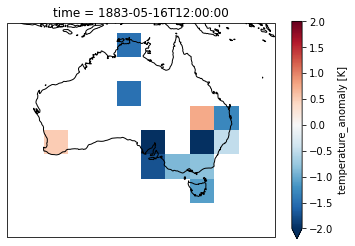

In [8]:
ax = plt.axes(projection=ccrs.PlateCarree())
crutem4.tmp[400].sel(lat=slice(-50,-10), lon=slice(110,160)).plot(ax=ax, cmap='RdBu_r', vmin = -2, vmax = 2)
ax.coastlines()

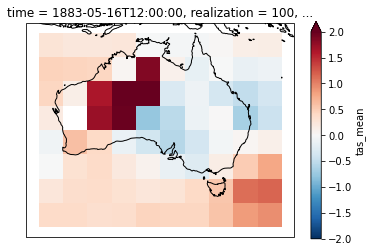

In [9]:
ax = plt.axes(projection=ccrs.PlateCarree())
hadcrut5_anom.tas_mean[400].sel(lat=slice(-50,-10), lon=slice(110,160)).plot(ax=ax, cmap='RdBu_r', vmin = -2, vmax = 2)
ax.coastlines()

In [10]:
# adjust the hadcrut data to a base climatology of 1850-1880
crutem4_anom = func.monthly_anomaly(crutem4, '1850', '1880')

### Area weighting and landmask for HadCrut5

In [12]:
# import landmask dataset 
landfrac_ds = xr.open_dataset('/g/data/w48/kb6999/Reanalysis/20CR_data_netcdfs/land_20CR.nc')
landmask = landfrac_ds

Do I need to area weight the HadCRUT data?

In [13]:
# area weighting 
hadcrut5_glob = hadcrut5_anom.tas_mean*np.cos(hadcrut5_anom.lat*(np.pi/180))
hadcrut5_glob

<xarray.DataArray (time: 1992, lat: 36, lon: 72)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 2015-12-16T12:...
  * lat          (lat) float64 -87.5 -82.5 -77.5 -72.5 ... 72.5 77.5 82.5 87.5
  * lon          (lon) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
    realization  int64 100
    month        (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12

## There is not data for every gridpoint

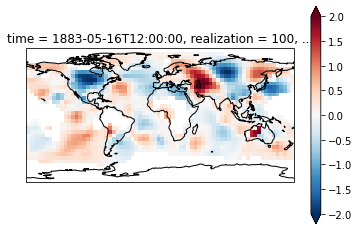

In [14]:
ax = plt.axes(projection=ccrs.PlateCarree())
hadcrut5_glob[400].plot(ax=ax, cmap='RdBu_r', vmin = -2, vmax = 2)
ax.coastlines()

## Note that I haven't used a landmask for Aus and EA this time!!

In [15]:
# Select out SH and NH anomalies 
hadcrut5_SH = hadcrut5_glob.sel(lat=slice(-90,0)) 
hadcrut5_NH = hadcrut5_glob.sel(lat=slice(0,90)) 
# select out the Australian and E Australian anomalies 
hadcrut5_Aus = hadcrut5_glob.sel(lat=slice(-50,-10), lon=slice(110,160))#.where(landmask.LAND==1.0, drop=True)
hadcrut5_EA = hadcrut5_glob.sel(lat=slice(-50,-10), lon=slice(140,155))#.where(landmask.LAND==1.0, drop=True)

In [16]:
# take the lat lon mean of the hadcrut5 obs data 
hadcrut5_llm = hadcrut5_glob.mean(dim=['lat','lon'])
hadcrut5_llm_SH = hadcrut5_SH.mean(dim=['lat','lon'])
hadcrut5_llm_Aus = hadcrut5_Aus.mean(dim=['lat','lon'])
hadcrut5_llm_EA = hadcrut5_EA.mean(dim=['lat','lon'])

# 20CR data

In [19]:
path = '/g/data/w48/kb6999/Reanalysis/20CR_TMP_data_for_plots/'

In [20]:
# open lat lon mean of temperature 
llm_Glob = xr.open_dataset(f'{path}llm_mon_Glob.nc')
llm_NH = xr.open_dataset(f'{path}llm_mon_NH.nc')
llm_SH = xr.open_dataset(f'{path}llm_mon_SH.nc')
llm_Aus = xr.open_dataset(f'{path}llm_mon_Aus.nc')
llm_EA = xr.open_dataset(f'{path}llm_mon_EA.nc')

In [21]:
# open multi member mean of temperature
mmm_mon_Glob = xr.open_dataset(f'{path}mmm_mon_Glob.nc')
mmm_mon_NH = xr.open_dataset(f'{path}mmm_mon_NH.nc')
mmm_mon_SH = xr.open_dataset(f'{path}mmm_mon_SH.nc')
mmm_mon_Aus = xr.open_dataset(f'{path}mmm_mon_Aus.nc')
mmm_mon_EA = xr.open_dataset(f'{path}mmm_mon_EA.nc')

In [22]:
# open percentile data for temperature
p10_mon_Glob = xr.open_dataset(f'{path}p10_mon_Glob.nc')
p10_mon_NH = xr.open_dataset(f'{path}p10_mon_NH.nc')
p10_mon_SH = xr.open_dataset(f'{path}p10_mon_SH.nc')
p10_mon_Aus = xr.open_dataset(f'{path}p10_mon_Aus.nc')
p10_mon_EA = xr.open_dataset(f'{path}p10_mon_EA.nc')

In [23]:
# open percentile data for temperature
p90_mon_Glob = xr.open_dataset(f'{path}p90_mon_Glob.nc')
p90_mon_NH = xr.open_dataset(f'{path}p90_mon_NH.nc')
p90_mon_SH = xr.open_dataset(f'{path}p90_mon_SH.nc')
p90_mon_Aus = xr.open_dataset(f'{path}p90_mon_Aus.nc')
p90_mon_EA = xr.open_dataset(f'{path}p90_mon_EA.nc')

### select out Krakatoa years 

In [24]:
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])

In [25]:
# save arrays of times relative to each eruption
e_pre5yrs = e_date - 60 * pd.offsets.MonthBegin()
e_pre3mon = e_date - 3 * pd.offsets.MonthBegin()
e_post5yrs = e_date + 61 * pd.offsets.MonthBegin()
e_post10yrs = e_date + 121 * pd.offsets.MonthBegin()

In [26]:
# Zoom in on Krakatoa time period
K_mmm_Glob = mmm_mon_Glob.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_SH = mmm_mon_SH.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_Aus = mmm_mon_Aus.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_EA = mmm_mon_EA.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p10_Glob = p10_mon_Glob.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_SH = p10_mon_SH.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_Aus = p10_mon_Aus.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_EA = p10_mon_EA.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p90_Glob = p90_mon_Glob.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_SH = p90_mon_SH.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_Aus = p90_mon_Aus.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_EA = p90_mon_EA.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

In [27]:
# Zoom in on Krakatoa time period for obs hadcrut data
K_hadcrut5_llm = hadcrut5_llm.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_hadcrut5_llm_SH = hadcrut5_llm_SH.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_hadcrut5_llm_Aus = hadcrut5_llm_Aus.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_hadcrut5_llm_EA = hadcrut5_llm_EA.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

## Figures

In [28]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

In [53]:
# set the default font size
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

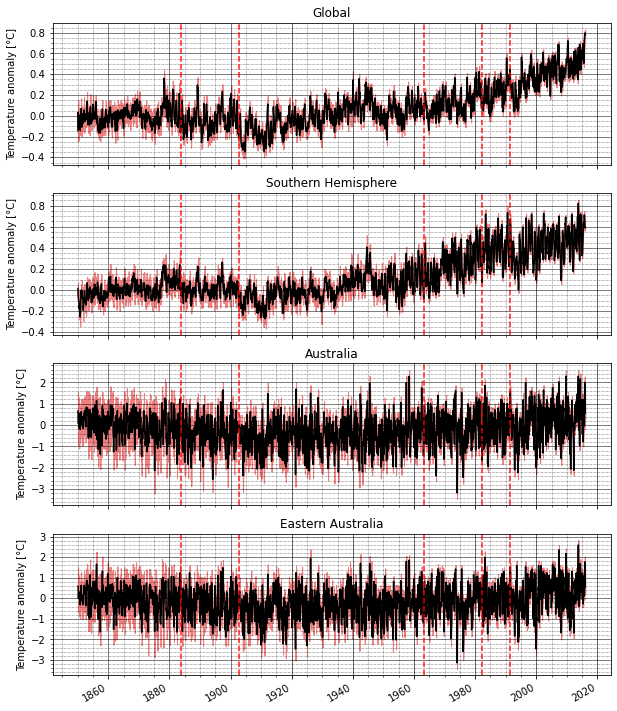

In [24]:
# no rolling mean gives too much variability - too hard to read 
# Monthly temperature anomalies stacked
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10,12)) # make a figure

with dask.diagnostics.ProgressBar():
    fplot.timeseries_graph(mmm_mon_Glob.tmp, p10_mon_Glob.tmp, p90_mon_Glob.tmp, ax = axes[0], color='lightcoral')
    fplot.timeseries_graph(mmm_mon_SH.tmp, p10_mon_SH.tmp, p90_mon_SH.tmp, ax = axes[1], color='lightcoral')
    fplot.timeseries_graph(mmm_mon_Aus.tmp, p10_mon_Aus.tmp, p90_mon_Aus.tmp, ax = axes[2], color='lightcoral')
    fplot.timeseries_graph(mmm_mon_EA.tmp, p10_mon_EA.tmp, p90_mon_EA.tmp, ax = axes[3], color='lightcoral')

axes[0].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Global') 
axes[1].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Southern Hemisphere')
axes[2].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Australia')
axes[3].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Eastern Australia')

#fig.suptitle('Time series of temperature anomalies', size=16)

#fig.tight_layout() # makes titles overlap, but is meant to stops things from overlapping and makes the figure more compact

plt.savefig('R_timeseries_mon_tmp_stacked.png', dpi=300, bbox_inches='tight')

In [29]:
# use this to set the x-ticks for each month from 5 years before to 5 years after the eruption
months = pd.date_range(e_pre5yrs[0], e_post5yrs[0], freq='MS')
years = pd.date_range(e_pre5yrs[0], e_post5yrs[0], freq='YS')

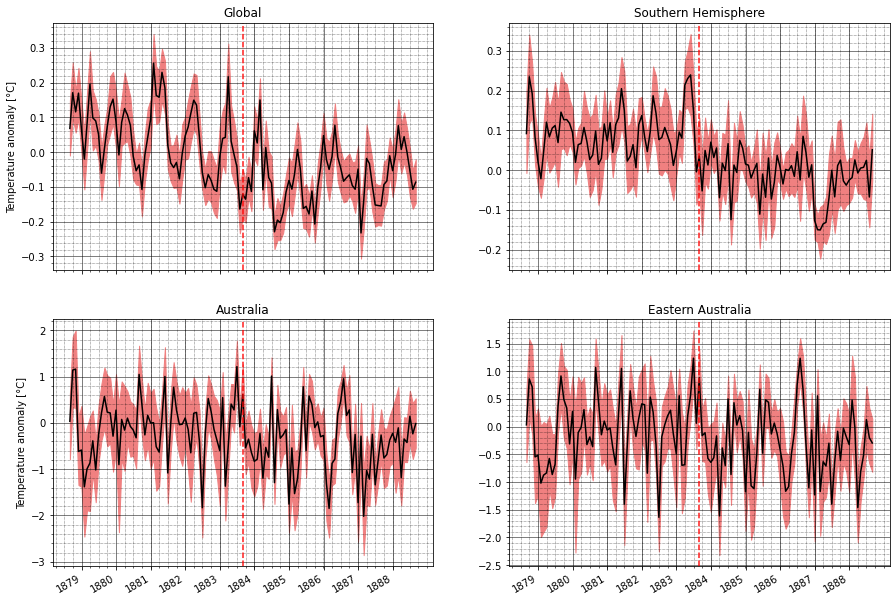

In [26]:
# Monthly temperature anomalies for Krakatoa
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,10)) # make a figure

# make subplots for each region
fplot.timeseries_graph(K_mmm_Glob.tmp, K_p10_Glob.tmp, K_p90_Glob.tmp, ax = axes[0,0], color='lightcoral')
fplot.timeseries_graph(K_mmm_SH.tmp, K_p10_SH.tmp, K_p90_SH.tmp, ax = axes[0,1], color='lightcoral')
fplot.timeseries_graph(K_mmm_Aus.tmp, K_p10_Aus.tmp, K_p90_Aus.tmp, ax = axes[1,0], color='lightcoral')
fplot.timeseries_graph(K_mmm_EA.tmp, K_p10_EA.tmp, K_p90_EA.tmp, ax = axes[1,1], color='lightcoral')

# set axis labels and subplot titles
axes[0,0].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Global') 
axes[0,1].set(title = 'Southern Hemisphere')
axes[1,0].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Australia')
axes[1,1].set(title = 'Eastern Australia')

# hadcrut5_llm_Aus.sel(time = slice(e_pre5yrs[0], e_post5yrs[0])).plot(ax=axes[1,0])

# set the axis ticks to be yearly 
axes[0,0].set_xticks(years)
axes[0,0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

plt.savefig('R_K_timeseries_mon_tmp.png', dpi=300, bbox_inches='tight')

## comparing HadCRUT5 and 20CR

In [30]:
fplot=reload(fplot)

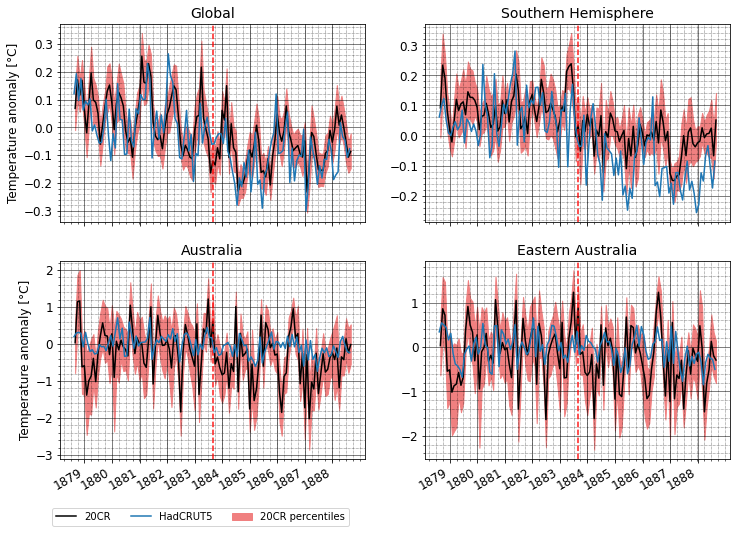

In [54]:
# Monthly precipitation anomalies for Krakatoa
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(12,8)) # make a figure

# make subplots for each region
l1 = fplot.timeseries_graph(K_mmm_Glob.tmp, K_p10_Glob.tmp, K_p90_Glob.tmp, ax = axes[0,0], color='lightcoral', l='20CR', label='20CR percentiles')
fplot.timeseries_graph(K_mmm_SH.tmp, K_p10_SH.tmp, K_p90_SH.tmp, ax = axes[0,1], color='lightcoral', l='20CR')
fplot.timeseries_graph(K_mmm_Aus.tmp, K_p10_Aus.tmp, K_p90_Aus.tmp, ax = axes[1,0], color='lightcoral', l='20CR')
fplot.timeseries_graph(K_mmm_EA.tmp, K_p10_EA.tmp, K_p90_EA.tmp, ax = axes[1,1], color='lightcoral', l='20CR')

l2 = K_hadcrut5_llm.plot(ax=axes[0,0], label = 'HadCRUT5')
K_hadcrut5_llm_SH.plot(ax=axes[0,1],  label = 'HadCRUT5')
K_hadcrut5_llm_Aus.plot(ax=axes[1,0], label = 'HadCRUT5')
K_hadcrut5_llm_EA.plot(ax=axes[1,1], label = 'HadCRUT5')

# set axis labels and subplot titles
axes[0,0].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Global') 
axes[0,1].set(title = 'Southern Hemisphere')
axes[1,0].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Australia')
axes[1,1].set(title = 'Eastern Australia')

# set the axis ticks to be monthly 
axes[0,0].set_xticks(years)
axes[0,0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

# remove xlabel
axes[0,0].set_xlabel(None)
axes[0,1].set_xlabel(None)
axes[1,0].set_xlabel(None)
axes[1,1].set_xlabel(None)

# axes[0,0].legend()

# make one legend for all tables (just use last axis to get info)  
handles, labels = axes[0, 0].get_legend_handles_labels()

# first arg to bbox is x second is y (x,y)
fig.legend(handles, labels, loc='lower left', bbox_to_anchor=(0.11, 0.0), ncol=3) 

plt.savefig('R_K_timeseries_tmp_hadcrut5.png', dpi=300, bbox_inches='tight')

## Analysis using Rolling mean 

In [39]:
# calculate rolling means of lat lon data for hadcrut
hadcrut5_glob_roll6 = hadcrut5_llm.rolling(time=6).mean()
hadcrut5_SH_roll6 = hadcrut5_llm_SH.rolling(time=6).mean()
hadcrut5_Aus_roll6 = hadcrut5_llm_Aus.rolling(time=6).mean()
hadcrut5_EA_roll6 = hadcrut5_llm_EA.rolling(time=6).mean()
hadcrut5_glob_roll12 = hadcrut5_llm.rolling(time=12).mean()
hadcrut5_SH_roll12 = hadcrut5_llm_SH.rolling(time=12).mean()
hadcrut5_Aus_roll12 = hadcrut5_llm_Aus.rolling(time=12).mean()
hadcrut5_EA_roll12 = hadcrut5_llm_EA.rolling(time=12).mean()

In [40]:
# calculate rolling means of lat lon data
llm_mon_Glob_roll6 = llm_Glob.rolling(time=6).mean()
llm_mon_NH_roll6 = llm_NH.rolling(time=6).mean()
llm_mon_SH_roll6 = llm_SH.rolling(time=6).mean()
llm_mon_Aus_roll6 = llm_Aus.rolling(time=6).mean()
llm_mon_EA_roll6 = llm_EA.rolling(time=6).mean()

In [41]:
# calculate rolling means
mmm_mon_Glob_roll6 = mmm_mon_Glob.rolling(time=6).mean()
mmm_mon_NH_roll6 = mmm_mon_NH.rolling(time=6).mean()
mmm_mon_SH_roll6 = mmm_mon_SH.rolling(time=6).mean()
mmm_mon_Aus_roll6 = mmm_mon_Aus.rolling(time=6).mean()
mmm_mon_EA_roll6 = mmm_mon_EA.rolling(time=6).mean()

In [42]:
# calculate rolling means
p10_mon_Glob_roll6 = p10_mon_Glob.rolling(time=6).mean()
p10_mon_NH_roll6 = p10_mon_NH.rolling(time=6).mean()
p10_mon_SH_roll6 = p10_mon_SH.rolling(time=6).mean()
p10_mon_Aus_roll6 = p10_mon_Aus.rolling(time=6).mean()
p10_mon_EA_roll6 = p10_mon_EA.rolling(time=6).mean()

In [43]:
# calculate rolling means
p90_mon_Glob_roll6 = p90_mon_Glob.rolling(time=6).mean()
p90_mon_NH_roll6 = p90_mon_NH.rolling(time=6).mean()
p90_mon_SH_roll6 = p90_mon_SH.rolling(time=6).mean()
p90_mon_Aus_roll6 = p90_mon_Aus.rolling(time=6).mean()
p90_mon_EA_roll6 = p90_mon_EA.rolling(time=6).mean()

In [44]:
# 3 month rolling mean and percentiles
mmm_mon_Glob_roll3 = mmm_mon_Glob.rolling(time=3).mean()
mmm_mon_Aus_roll3 = mmm_mon_Aus.rolling(time=3).mean()

p10_mon_Glob_roll3 = p10_mon_Glob.rolling(time=3).mean()
p10_mon_Aus_roll3 = p10_mon_Aus.rolling(time=3).mean()

p90_mon_Glob_roll3 = p90_mon_Glob.rolling(time=3).mean()
p90_mon_Aus_roll3 = p90_mon_Aus.rolling(time=3).mean()

# 12 month rolling mean and percentiles for all 4 regions
mmm_mon_Glob_roll12 = mmm_mon_Glob.rolling(time=12).mean()
mmm_mon_SH_roll12 = mmm_mon_SH.rolling(time=12).mean()
mmm_mon_Aus_roll12 = mmm_mon_Aus.rolling(time=12).mean()
mmm_mon_EA_roll12 = mmm_mon_EA.rolling(time=12).mean()

p10_mon_Glob_roll12 = p10_mon_Glob.rolling(time=12).mean()
p10_mon_SH_roll12 = p10_mon_SH.rolling(time=12).mean()
p10_mon_Aus_roll12 = p10_mon_Aus.rolling(time=12).mean()
p10_mon_EA_roll12 = p10_mon_EA.rolling(time=12).mean()

p90_mon_Glob_roll12 = p90_mon_Glob.rolling(time=12).mean()
p90_mon_SH_roll12 = p90_mon_SH.rolling(time=12).mean()
p90_mon_Aus_roll12 = p90_mon_Aus.rolling(time=12).mean()
p90_mon_EA_roll12 = p90_mon_EA.rolling(time=12).mean()

# 24 month rolling mean and percentiles 
mmm_mon_Glob_roll24 = mmm_mon_Glob.rolling(time=24).mean()
mmm_mon_Aus_roll24 = mmm_mon_Aus.rolling(time=24).mean()

p10_mon_Glob_roll24 = p10_mon_Glob.rolling(time=24).mean()
p10_mon_Aus_roll24 = p10_mon_Aus.rolling(time=24).mean()

p90_mon_Glob_roll24 = p90_mon_Glob.rolling(time=24).mean()
p90_mon_Aus_roll24 = p90_mon_Aus.rolling(time=24).mean()


## Rolling mean

In [62]:
fplot=reload(fplot)

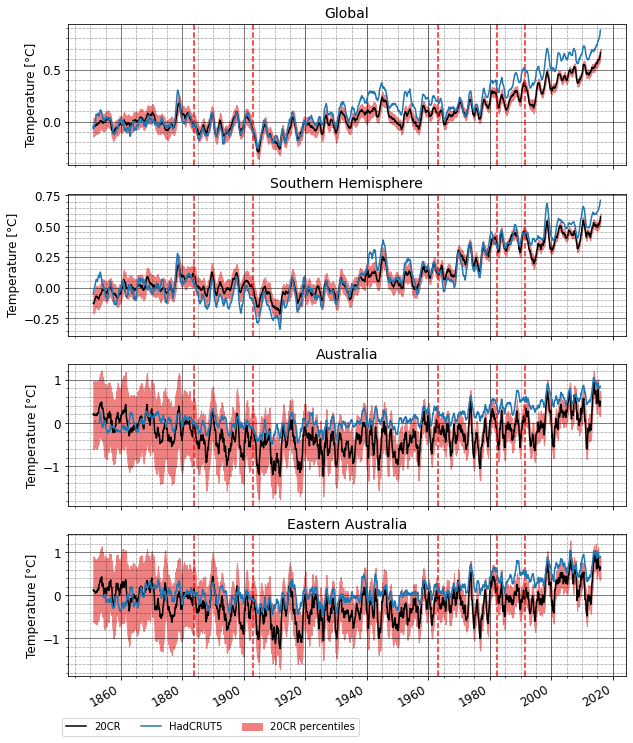

In [64]:
# Monthly temperature anomalies stacked
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10,12)) # make a figure

with dask.diagnostics.ProgressBar():
    fplot.timeseries_graph(mmm_mon_Glob_roll12.tmp, p10_mon_Glob_roll12.tmp, p90_mon_Glob_roll12.tmp, ax = axes[0], color='lightcoral', l='20CR', label='20CR percentiles')
    fplot.timeseries_graph(mmm_mon_SH_roll12.tmp, p10_mon_SH_roll12.tmp, p90_mon_SH_roll12.tmp, ax = axes[1], color='lightcoral')
    fplot.timeseries_graph(mmm_mon_Aus_roll12.tmp, p10_mon_Aus_roll12.tmp, p90_mon_Aus_roll12.tmp, ax = axes[2], color='lightcoral')
    fplot.timeseries_graph(mmm_mon_EA_roll12.tmp, p10_mon_EA_roll12.tmp, p90_mon_EA_roll12.tmp, ax = axes[3], color='lightcoral')

hadcrut5_glob_roll12.plot(ax=axes[0], label='HadCRUT5')
hadcrut5_SH_roll12.plot(ax=axes[1])
hadcrut5_Aus_roll12.plot(ax=axes[2])
hadcrut5_EA_roll12.plot(ax=axes[3])
    
axes[0].set(ylabel= f'Temperature [{deg}C]', title = 'Global') 
axes[1].set(ylabel= f'Temperature [{deg}C]', title = 'Southern Hemisphere')
axes[2].set(ylabel= f'Temperature [{deg}C]', title = 'Australia')
axes[3].set(ylabel= f'Temperature [{deg}C]', title = 'Eastern Australia')

# remove xlabel
axes[0].set_xlabel(None)
axes[1].set_xlabel(None)
axes[2].set_xlabel(None)
axes[3].set_xlabel(None)

# make one legend for all tables (just use last axis to get info)  
handles, labels = axes[0].get_legend_handles_labels()

# first arg to bbox is x second is y (x,y)
fig.legend(handles, labels, loc='lower left', bbox_to_anchor=(0.11, 0.05), ncol=3) 

plt.savefig('R_timeseries_mon_tmp_hadcrut_roll12.png', dpi=300, bbox_inches='tight')

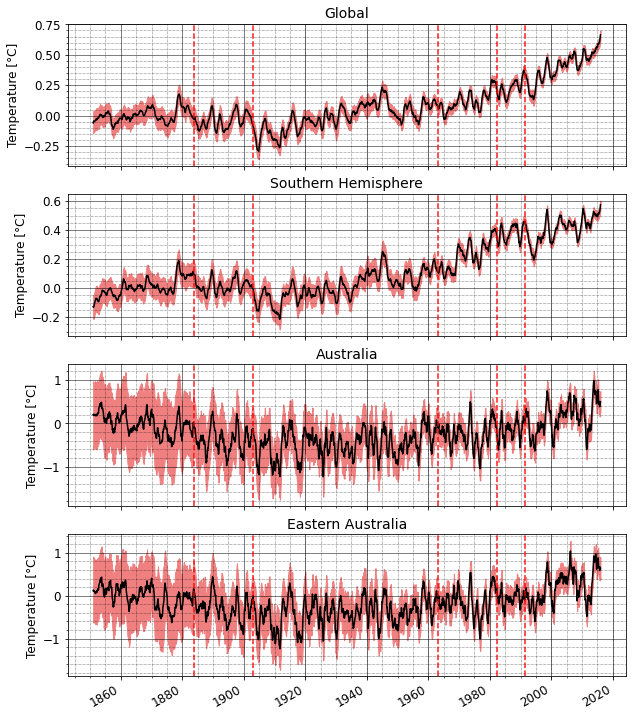

In [65]:
# Monthly temperature anomalies stacked
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10,12)) # make a figure

with dask.diagnostics.ProgressBar():
    fplot.timeseries_graph(mmm_mon_Glob_roll12.tmp, p10_mon_Glob_roll12.tmp, p90_mon_Glob_roll12.tmp, ax = axes[0], color='lightcoral')
    fplot.timeseries_graph(mmm_mon_SH_roll12.tmp, p10_mon_SH_roll12.tmp, p90_mon_SH_roll12.tmp, ax = axes[1], color='lightcoral')
    fplot.timeseries_graph(mmm_mon_Aus_roll12.tmp, p10_mon_Aus_roll12.tmp, p90_mon_Aus_roll12.tmp, ax = axes[2], color='lightcoral')
    fplot.timeseries_graph(mmm_mon_EA_roll12.tmp, p10_mon_EA_roll12.tmp, p90_mon_EA_roll12.tmp, ax = axes[3], color='lightcoral')

    
axes[0].set(ylabel= f'Temperature [{deg}C]', title = 'Global') 
axes[1].set(ylabel= f'Temperature [{deg}C]', title = 'Southern Hemisphere')
axes[2].set(ylabel= f'Temperature [{deg}C]', title = 'Australia')
axes[3].set(ylabel= f'Temperature [{deg}C]', title = 'Eastern Australia')

# remove xlabel
axes[0].set_xlabel(None)
axes[1].set_xlabel(None)
axes[2].set_xlabel(None)
axes[3].set_xlabel(None)

plt.savefig('R_timeseries_mon_tmp_roll12.png', dpi=300, bbox_inches='tight')

In [66]:
# rolling mean version
K_mmm_Glob_roll6 = mmm_mon_Glob_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_SH_roll6 = mmm_mon_SH_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_Aus_roll6 = mmm_mon_Aus_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_EA_roll6 = mmm_mon_EA_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p10_Glob_roll6 = p10_mon_Glob_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_SH_roll6 = p10_mon_SH_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_Aus_roll6 = p10_mon_Aus_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_EA_roll6 = p10_mon_EA_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p90_Glob_roll6 = p90_mon_Glob_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_SH_roll6 = p90_mon_SH_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_Aus_roll6 = p90_mon_Aus_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_EA_roll6 = p90_mon_EA_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

In [70]:
# rolling mean zoomed in for Krakatoa time period
# 3 month rolling mean and precentiles
K_mmm_Glob_roll3 = mmm_mon_Glob_roll3.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_Aus_roll3 = mmm_mon_Aus_roll3.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p10_Glob_roll3 = p10_mon_Glob_roll3.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_Aus_roll3 = p10_mon_Aus_roll3.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p90_Glob_roll3 = p90_mon_Glob_roll3.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_Aus_roll3 = p90_mon_Aus_roll3.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

# 12 month rolling mean and precentiles
K_mmm_Glob_roll12 = mmm_mon_Glob_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_SH_roll12 = mmm_mon_SH_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_Aus_roll12 = mmm_mon_Aus_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_EA_roll12 = mmm_mon_EA_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p10_Glob_roll12 = p10_mon_Glob_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_SH_roll12 = p10_mon_SH_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_Aus_roll12 = p10_mon_Aus_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_EA_roll12 = p10_mon_EA_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p90_Glob_roll12 = p90_mon_Glob_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_SH_roll12 = p90_mon_SH_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_Aus_roll12 = p90_mon_Aus_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_EA_roll12 = p90_mon_EA_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))


# 3 month rolling mean and precentiles
K_mmm_Glob_roll24 = mmm_mon_Glob_roll24.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_Aus_roll24 = mmm_mon_Aus_roll24.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p10_Glob_roll24 = p10_mon_Glob_roll24.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_Aus_roll24 = p10_mon_Aus_roll24.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p90_Glob_roll24 = p90_mon_Glob_roll24.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_Aus_roll24 = p90_mon_Aus_roll24.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))


In [68]:
# zoom in on krakatoa rolling mean for hadcrut data
K_hadcrut5_glob_roll6 = hadcrut5_glob_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_hadcrut5_SH_roll6 = hadcrut5_SH_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_hadcrut5_Aus_roll6 = hadcrut5_Aus_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_hadcrut5_EA_roll6 = hadcrut5_EA_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_hadcrut5_glob_roll12 = hadcrut5_glob_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_hadcrut5_SH_roll12 = hadcrut5_SH_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_hadcrut5_Aus_roll12 = hadcrut5_Aus_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_hadcrut5_EA_roll12 = hadcrut5_EA_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

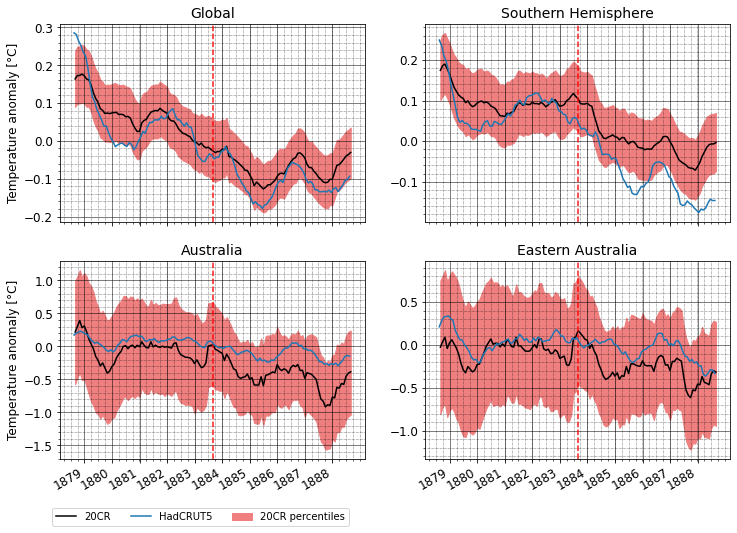

In [71]:
# Monthly temp anomalies for Krakatoa
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(12,8)) # make a figure

# make subplots for each region
l1 = fplot.timeseries_graph(K_mmm_Glob_roll12.tmp, K_p10_Glob_roll12.tmp, K_p90_Glob_roll12.tmp, ax = axes[0,0], color='lightcoral', l='20CR', label='20CR percentiles')
fplot.timeseries_graph(K_mmm_SH_roll12.tmp, K_p10_SH_roll12.tmp, K_p90_SH_roll12.tmp, ax = axes[0,1], color='lightcoral')
fplot.timeseries_graph(K_mmm_Aus_roll12.tmp, K_p10_Aus_roll12.tmp, K_p90_Aus_roll12.tmp, ax = axes[1,0], color='lightcoral')
fplot.timeseries_graph(K_mmm_EA_roll12.tmp, K_p10_EA_roll12.tmp, K_p90_EA_roll12.tmp, ax = axes[1,1], color='lightcoral')

l2 = K_hadcrut5_glob_roll12.plot(ax=axes[0,0], label = 'HadCRUT5')
K_hadcrut5_SH_roll12.plot(ax=axes[0,1])
K_hadcrut5_Aus_roll12.plot(ax=axes[1,0])
K_hadcrut5_EA_roll12.plot(ax=axes[1,1])

# set axis labels and subplot titles
axes[0,0].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Global') 
axes[0,1].set(title = 'Southern Hemisphere')
axes[1,0].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Australia')
axes[1,1].set(title = 'Eastern Australia')

# set the axis ticks to be monthly 
axes[0,0].set_xticks(years)
axes[0,0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

# remove xlabel
axes[0,0].set_xlabel(None)
axes[0,1].set_xlabel(None)
axes[1,0].set_xlabel(None)
axes[1,1].set_xlabel(None)

# axes[0,0].legend()

# make one legend for all tables (just use last axis to get info)  
handles, labels = axes[0, 0].get_legend_handles_labels()
# first arg to bbox is x second is y (x,y)
fig.legend(handles, labels, loc='lower left', bbox_to_anchor=(0.11, 0.0), ncol=3) 

plt.savefig('R_K_timeseries_tmp_hadcrut5_roll12.png', dpi=300, bbox_inches='tight')

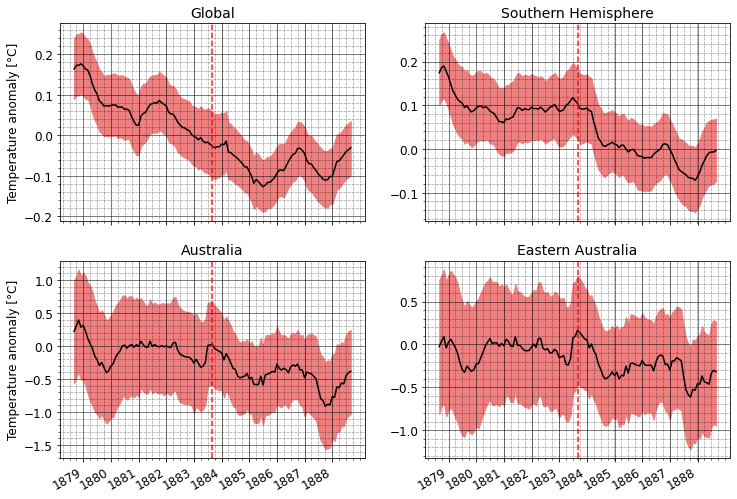

In [72]:
# Monthly temp anomalies for Krakatoa
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(12,8)) # make a figure

# make subplots for each region
l1 = fplot.timeseries_graph(K_mmm_Glob_roll12.tmp, K_p10_Glob_roll12.tmp, K_p90_Glob_roll12.tmp, ax = axes[0,0], color='lightcoral')
fplot.timeseries_graph(K_mmm_SH_roll12.tmp, K_p10_SH_roll12.tmp, K_p90_SH_roll12.tmp, ax = axes[0,1], color='lightcoral')
fplot.timeseries_graph(K_mmm_Aus_roll12.tmp, K_p10_Aus_roll12.tmp, K_p90_Aus_roll12.tmp, ax = axes[1,0], color='lightcoral')
fplot.timeseries_graph(K_mmm_EA_roll12.tmp, K_p10_EA_roll12.tmp, K_p90_EA_roll12.tmp, ax = axes[1,1], color='lightcoral')



# set axis labels and subplot titles
axes[0,0].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Global') 
axes[0,1].set(title = 'Southern Hemisphere')
axes[1,0].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Australia')
axes[1,1].set(title = 'Eastern Australia')

# set the axis ticks to be monthly 
axes[0,0].set_xticks(years)
axes[0,0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

# remove xlabel
axes[0,0].set_xlabel(None)
axes[0,1].set_xlabel(None)
axes[1,0].set_xlabel(None)
axes[1,1].set_xlabel(None)


plt.savefig('R_K_timeseries_tmp_roll12.png', dpi=300, bbox_inches='tight')

## stats

In [79]:
# calculate the time time difference time series for HadCRUT and 20CR for Australia and globe
K_hadcrut5_diff_Glob = K_hadcrut5_llm.diff('time')
K_diff_Glob = K_mmm_Glob.tmp.diff('time')

K_hadcrut5_diff_SH = K_hadcrut5_llm_SH.diff('time')
K_diff_SH = K_mmm_SH.tmp.diff('time')

K_hadcrut5_diff_Aus = K_hadcrut5_llm_Aus.diff('time')
K_diff_Aus = K_mmm_Aus.tmp.diff('time')

K_hadcrut5_diff_EA = K_hadcrut5_llm_EA.diff('time')
K_diff_EA = K_mmm_EA.tmp.diff('time')

In [81]:
# calculate correlation between the two time difference arrays
print(scipy.stats.pearsonr(K_hadcrut5_diff_Glob, K_diff_Glob))#[0]    # Pearson's r

(0.48617224441460355, 1.809669880926547e-08)


In [82]:
# calculate correlation between the two time difference arrays
print(scipy.stats.pearsonr(K_hadcrut5_diff_SH, K_diff_SH))#[0]    # Pearson's r

(0.11317213321546979, 0.2184273741939727)


In [83]:
# calculate correlation between the two time difference arrays
print(scipy.stats.pearsonr(K_hadcrut5_diff_Aus, K_diff_Aus))#[0]    # Pearson's r

(0.6783321701535834, 1.7152797507649015e-17)


In [84]:
# calculate correlation between the two time difference arrays
print(scipy.stats.pearsonr(K_hadcrut5_diff_EA, K_diff_EA))#[0]    # Pearson's r

(0.6736266212116286, 3.4469135242191044e-17)


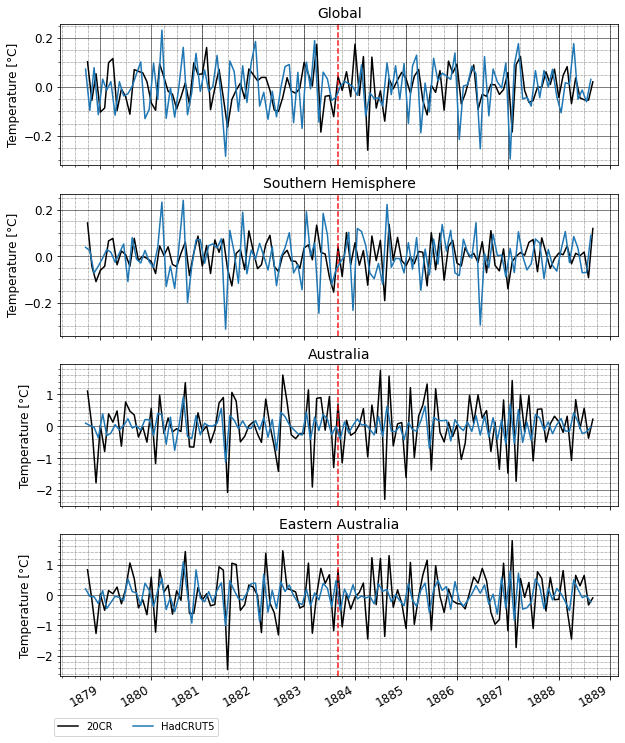

In [87]:
# Monthly temperature anomalies stacked
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10,12)) # make a figure

with dask.diagnostics.ProgressBar():
    fplot.timeseries_graph(K_diff_Glob, ax = axes[0], color='lightcoral', l='20CR')
    fplot.timeseries_graph(K_diff_SH, ax = axes[1], color='lightcoral')
    fplot.timeseries_graph(K_diff_Aus, ax = axes[2], color='lightcoral')
    fplot.timeseries_graph(K_diff_EA, ax = axes[3], color='lightcoral')

K_hadcrut5_diff_Glob.plot(ax=axes[0], label='HadCRUT5')
K_hadcrut5_diff_SH.plot(ax=axes[1])
K_hadcrut5_diff_Aus.plot(ax=axes[2])
K_hadcrut5_diff_EA.plot(ax=axes[3])
    
axes[0].set(ylabel= f'Temperature [{deg}C]', title = 'Global') 
axes[1].set(ylabel= f'Temperature [{deg}C]', title = 'Southern Hemisphere')
axes[2].set(ylabel= f'Temperature [{deg}C]', title = 'Australia')
axes[3].set(ylabel= f'Temperature [{deg}C]', title = 'Eastern Australia')


# remove xlabel
axes[0].set_xlabel(None)
axes[1].set_xlabel(None)
axes[2].set_xlabel(None)
axes[3].set_xlabel(None)

# make one legend for all tables (just use last axis to get info)  
handles, labels = axes[0].get_legend_handles_labels()
# first arg to bbox is x second is y (x,y)
fig.legend(handles, labels, loc='lower left', bbox_to_anchor=(0.11, 0.05), ncol=2) 

plt.savefig('R_timeseries_diff_tmp_hadcrut.png', dpi=300, bbox_inches='tight')

### ten years around Krakatoa

In [88]:
# calculate the correlation coefficient using different methods for the ten years surrounds the krakatoa eruption 
print(scipy.stats.pearsonr(K_hadcrut5_llm, K_mmm_Glob.tmp))#[0]    # Pearson's r
print(scipy.stats.spearmanr(K_hadcrut5_llm, K_mmm_Glob.tmp))#[0]   # Spearman's rho
print(scipy.stats.kendalltau(K_hadcrut5_llm, K_mmm_Glob.tmp))#[0]  # Kendall's tau

(0.7361898780698058, 6.548736833977672e-22)
SpearmanrResult(correlation=0.6994851646118411, pvalue=4.484472496659976e-19)
KendalltauResult(correlation=0.5176308539944903, pvalue=3.796652974488818e-17)


In [98]:
# calculate the correlation coefficient using different methods for the ten years surrounds the krakatoa eruption 
print(scipy.stats.pearsonr(K_hadcrut5_llm_SH, K_mmm_SH.tmp))#[0]    # Pearson's r

(0.6215214928449885, 2.8062260800536526e-14)


In [99]:
# calculate correlation using different methods for Australia for the ten years surrounds the krakatoa eruption 
print(scipy.stats.pearsonr(K_hadcrut5_llm_Aus, K_mmm_Aus.tmp))#[0]    # Pearson's r

(0.6194481214035741, 3.6109833691349994e-14)


In [90]:
# calculate correlation using different methods for E Australia for the ten years surrounds the krakatoa eruption 
print(scipy.stats.pearsonr(K_hadcrut5_llm_EA, K_mmm_EA.tmp))#[0]    # Pearson's r
print(scipy.stats.spearmanr(K_hadcrut5_llm_EA, K_mmm_EA.tmp))#[0]   # Spearman's rho
print(scipy.stats.kendalltau(K_hadcrut5_llm_EA, K_mmm_EA.tmp))#[0]  # Kendall's tau

(0.5582988454112734, 2.861910733642905e-11)
SpearmanrResult(correlation=0.5405839317165694, pvalue=1.551085365432322e-10)
KendalltauResult(correlation=0.38099173553719007, pvalue=5.767925205847232e-10)


In [91]:
# calculate the correlation coefficient using different methods for 1870-1900
print(scipy.stats.pearsonr(hadcrut5_llm.sel(time=slice('1870','1900')), mmm_mon_Glob.tmp.sel(time=slice('1870','1900'))))#[0]    # Pearson's r
print(scipy.stats.spearmanr(hadcrut5_llm.sel(time=slice('1870','1900')), mmm_mon_Glob.tmp.sel(time=slice('1870','1900'))))#[0]   # Spearman's rho
print(scipy.stats.kendalltau(hadcrut5_llm.sel(time=slice('1870','1900')), mmm_mon_Glob.tmp.sel(time=slice('1870','1900'))))#[0]  # Kendall's tau

(0.707297072528135, 1.0788853347678727e-57)
SpearmanrResult(correlation=0.6712410833607427, pvalue=4.7188275003371635e-50)
KendalltauResult(correlation=0.48842129669883777, pvalue=6.293556453559837e-45)


In [92]:
# calculate the correlation coefficient using different methods for 1870-1900 for Aus
print(scipy.stats.pearsonr(hadcrut5_llm_Aus.sel(time=slice('1870','1900')), mmm_mon_Aus.tmp.sel(time=slice('1870','1900'))))#[0]    # Pearson's r
print(scipy.stats.spearmanr(hadcrut5_llm_Aus.sel(time=slice('1870','1900')), mmm_mon_Aus.tmp.sel(time=slice('1870','1900'))))#[0]   # Spearman's rho

(0.5507047817575906, 6.922381149311245e-31)
SpearmanrResult(correlation=0.5371261573477816, pvalue=3.4394138212318823e-29)


In [93]:
# calculate the correlation coefficient using different methods for 1970-2000
print(scipy.stats.pearsonr(hadcrut5_llm.sel(time=slice('1970','2000')), mmm_mon_Glob.tmp.sel(time=slice('1970','2000'))))#[0]    # Pearson's r
print(scipy.stats.spearmanr(hadcrut5_llm.sel(time=slice('1970','2000')), mmm_mon_Glob.tmp.sel(time=slice('1970','2000'))))#[0]   # Spearman's rho
print(scipy.stats.kendalltau(hadcrut5_llm.sel(time=slice('1970','2000')), mmm_mon_Glob.tmp.sel(time=slice('1970','2000'))))#[0]  # Kendall's tau

(0.8605025900028936, 2.0357461714259766e-110)
SpearmanrResult(correlation=0.8420419438990384, pvalue=3.17961044645405e-101)
KendalltauResult(correlation=0.6492478914876966, pvalue=5.3983469348924565e-78)


In [94]:
# calculate the correlation coefficient using different methods for 1970-2000 for AUs
print(scipy.stats.pearsonr(hadcrut5_llm_Aus.sel(time=slice('1970','2000')), mmm_mon_Aus.tmp.sel(time=slice('1970','2000'))))#[0]    # Pearson's r
print(scipy.stats.spearmanr(hadcrut5_llm_Aus.sel(time=slice('1970','2000')), mmm_mon_Aus.tmp.sel(time=slice('1970','2000'))))#[0]   # Spearman's rho

(0.809428744462805, 1.4606552251524227e-87)
SpearmanrResult(correlation=0.8177575420064883, pvalue=8.682921709976822e-91)


## entire time period

In [100]:
# calculate the correlation coefficient using different methods for the entire time period
print(scipy.stats.pearsonr(hadcrut5_llm, mmm_mon_Glob.tmp))#[0]    # Pearson's r

(0.9254459001893742, 0.0)


In [101]:
# calculate the correlation coefficient using different methods for the entire time period
print(scipy.stats.pearsonr(hadcrut5_llm_Aus, mmm_mon_Aus.tmp))#[0]    # Pearson's r

ValueError: array must not contain infs or NaNs

Pearson correlation coefficient and p-value for testing non-correlation.

The Pearson correlation coefficient [1] measures the linear relationship between two datasets. The calculation of the p-value relies on the assumption that each dataset is normally distributed. (See Kowalski [3] for a discussion of the effects of non-normality of the input on the distribution of the correlation coefficient.) Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact linear relationship. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases.

The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Pearson correlation at least as extreme as the one computed from these datasets.
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html

The Spearman rank-order correlation coefficient is a nonparametric measure of the monotonicity of the relationship between two datasets. Unlike the Pearson correlation, the Spearman correlation does not assume that both datasets are normally distributed. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact monotonic relationship. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases.

The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Spearman correlation at least as extreme as the one computed from these datasets. The p-values are not entirely reliable but are probably reasonable for datasets larger than 500 or so.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html

Calculate Kendall�s tau, a correlation measure for ordinal data.

Kendall�s tau is a measure of the correspondence between two rankings. Values close to 1 indicate strong agreement, and values close to -1 indicate strong disagreement. This implements two variants of Kendall�s tau: tau-b (the default) and tau-c (also known as Stuart�s tau-c). These differ only in how they are normalized to lie within the range -1 to 1; the hypothesis tests (their p-values) are identical. Kendall�s original tau-a is not implemented separately because both tau-b and tau-c reduce to tau-a in the absence of ties.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html

In [60]:
mon_array = [1, 3, 6, 12, 24]

### function below not working, roll should just be a simple 1d array (like mon_array above) but instead it's an xarray

In [122]:
# function to calculate the rolling mean of an array, 
# it can calculate rolling means using different time periods specified in the array 'mon_array' and concat them into one array

def roll_array(ds, mon_array):
    ds_roll=[]
    for m in mon_array: 
        roll = ds.rolling(time=m).mean()
        ds_roll.append(roll)

    # store all roolling means in an array
    roll_array = xr.concat(ds_roll, dim='roll', coords = 'minimal')
    roll_array.coords['roll'] = ['1','3','6','12','24']
    
    return roll_array

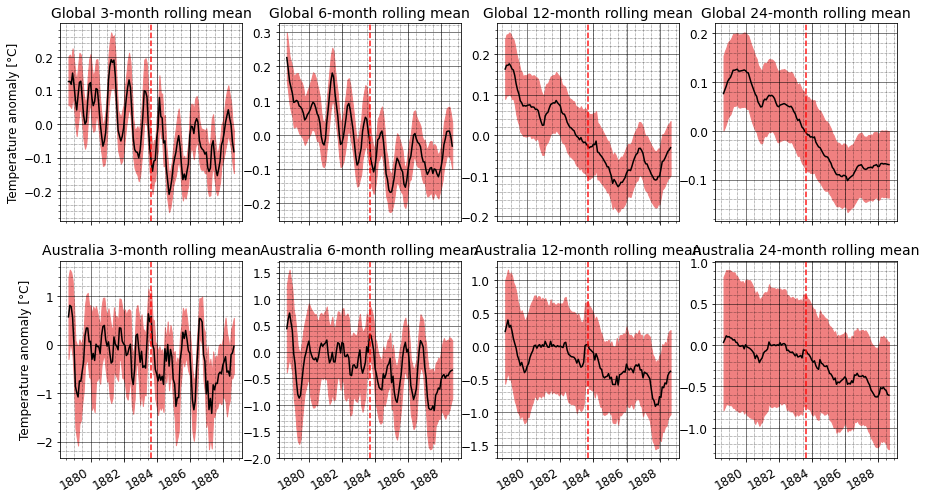

In [97]:
# Monthly precipitation anomalies for Krakatoa
fig, axes = plt.subplots(2, 4, sharex=True, figsize=(15,8)) # make a figure

# make subplots for each region
fplot.timeseries_graph(K_mmm_Glob_roll3.tmp, K_p10_Glob_roll3.tmp, K_p90_Glob_roll3.tmp, ax = axes[0,0], color='lightcoral')
fplot.timeseries_graph(K_mmm_Glob_roll6.tmp, K_p10_Glob_roll6.tmp, K_p90_Glob_roll6.tmp, ax = axes[0,1], color='lightcoral')
fplot.timeseries_graph(K_mmm_Glob_roll12.tmp, K_p10_Glob_roll12.tmp, K_p90_Glob_roll12.tmp, ax = axes[0,2], color='lightcoral')
fplot.timeseries_graph(K_mmm_Glob_roll24.tmp, K_p10_Glob_roll24.tmp, K_p90_Glob_roll24.tmp, ax = axes[0,3], color='lightcoral')
fplot.timeseries_graph(K_mmm_Aus_roll3.tmp, K_p10_Aus_roll3.tmp, K_p90_Aus_roll3.tmp, ax = axes[1,0], color='lightcoral')
fplot.timeseries_graph(K_mmm_Aus_roll6.tmp, K_p10_Aus_roll6.tmp, K_p90_Aus_roll6.tmp, ax = axes[1,1], color='lightcoral')
fplot.timeseries_graph(K_mmm_Aus_roll12.tmp, K_p10_Aus_roll12.tmp, K_p90_Aus_roll12.tmp, ax = axes[1,2], color='lightcoral')
fplot.timeseries_graph(K_mmm_Aus_roll24.tmp, K_p10_Aus_roll24.tmp, K_p90_Aus_roll24.tmp, ax = axes[1,3], color='lightcoral')

# set axis labels and subplot titles
axes[0,0].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Global 3-month rolling mean') 
axes[0,1].set(title = 'Global 6-month rolling mean')
axes[0,2].set(title = 'Global 12-month rolling mean')
axes[0,3].set(title = 'Global 24-month rolling mean')
axes[1,0].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Australia 3-month rolling mean')
axes[1,1].set(title = 'Australia 6-month rolling mean')
axes[1,2].set(title = 'Australia 12-month rolling mean')
axes[1,3].set(title = 'Australia 24-month rolling mean')



# set the axis ticks to be monthly 
# axes[0,0].set_xticks(years)
# axes[0,0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

plt.savefig('R_K_timeseries_mon_tmp_rolling3-6-12-24.png', dpi=300, bbox_inches='tight')

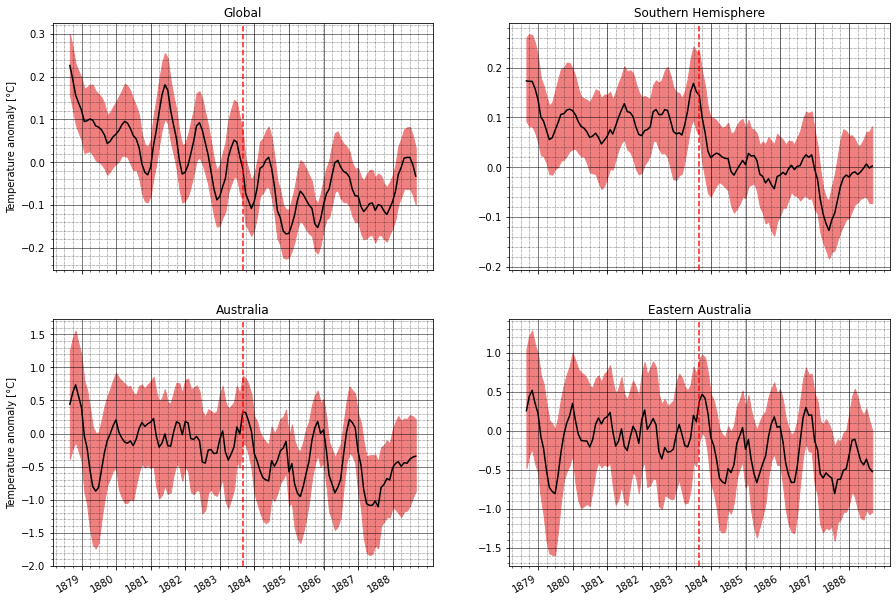

In [84]:
# Monthly precipitation anomalies for Krakatoa
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,10)) # make a figure

# make subplots for each region
fplot.timeseries_graph(K_mmm_Glob_roll6.tmp, K_p10_Glob_roll6.tmp, K_p90_Glob_roll6.tmp, ax = axes[0,0], color='lightcoral')
fplot.timeseries_graph(K_mmm_SH_roll6.tmp, K_p10_SH_roll6.tmp, K_p90_SH_roll6.tmp, ax = axes[0,1], color='lightcoral')
fplot.timeseries_graph(K_mmm_Aus_roll6.tmp, K_p10_Aus_roll6.tmp, K_p90_Aus_roll6.tmp, ax = axes[1,0], color='lightcoral')
fplot.timeseries_graph(K_mmm_EA_roll6.tmp, K_p10_EA_roll6.tmp, K_p90_EA_roll6.tmp, ax = axes[1,1], color='lightcoral')

# set axis labels and subplot titles
axes[0,0].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Global') 
axes[0,1].set(title = 'Southern Hemisphere')
axes[1,0].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Australia')
axes[1,1].set(title = 'Eastern Australia')

# set the axis ticks to be monthly 
axes[0,0].set_xticks(years)
axes[0,0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

plt.savefig('R_K_timeseries_mon_tmp_rolling6.png', dpi=300, bbox_inches='tight')

## rolling means